## Imports

In [11]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer
import xgboost as xgb


import pickle
import yaml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

In [12]:
import importlib
import preprocess
importlib.reload(preprocess)
from preprocess import Preprocessor


with open("./saved_scalers/minmaxscaler.pkl", 'rb') as file:
        saved_scaler = pickle.load(file)

p = Preprocessor(saved_std=saved_scaler)

## Loading saved models

In [13]:
with open('./saved_models/Random Forest/rf_model.pkl', 'rb') as file:
        rf_model = pickle.load(file)

with open('./saved_models/XGBoost/xgb_model.pkl', 'rb') as f:
        xgb_model = pickle.load(f)

## Test Data Preprocessing

In [14]:
# Loading data
raw_test = pd.read_table("../Data/test_FD001.txt", sep=' ', header=None)
rul_values = pd.read_table("../Data/RUL_FD001.txt", names=['remaining_cycles'])

In [15]:
# Retaining only the latest sensor values for each unit
raw_test = raw_test.groupby(raw_test.iloc[:, 0]).last()
y_test = pd.read_table("../Data/RUL_FD001.txt", names=['remaining_cycles']).values

In [16]:
preprocessing_pipeline = Pipeline([
    ("rename columns", FunctionTransformer(p.rename_columns, validate=False)),
    ("drop na", FunctionTransformer(p.dropna)),
    ("drop no info columns", FunctionTransformer(p.drop_no_info_cols)),
    ("dropping unit column", FunctionTransformer(p.drop_unit)),
    ("updating col groups", FunctionTransformer(p.update_col_groups)),    # returns the df from prev step
    ("Normalizing data", FunctionTransformer(p.normalize_predictors, kw_args={'cols':['cycles']+p.get_sensor_cols()+p.get_op_setting_cols()}))
])

In [17]:
processed_X_test = preprocessing_pipeline.fit_transform(raw_test)

## Model Predictions

In [18]:
rf_pred = rf_model.predict(processed_X_test)
mse = mean_squared_error(y_test, rf_pred)
rmse = np.sqrt(mse)

print("Random Forest Model Test results:")
print(f'Root Mean Squared Error: {rmse}')


Random Forest Model Test results:
Root Mean Squared Error: 55.03478151165949


In [19]:
xgb_pred = xgb_model.predict(processed_X_test)
mse = mean_squared_error(y_test.reshape(-1), xgb_pred)
rmse = np.sqrt(mse)

print("XGBoost Model Test results:")
print(f'Root Mean Squared Error: {rmse}')

XGBoost Model Test results:
Root Mean Squared Error: 37.7136621464954


### Plotting actual vs predicted values

<Axes: >

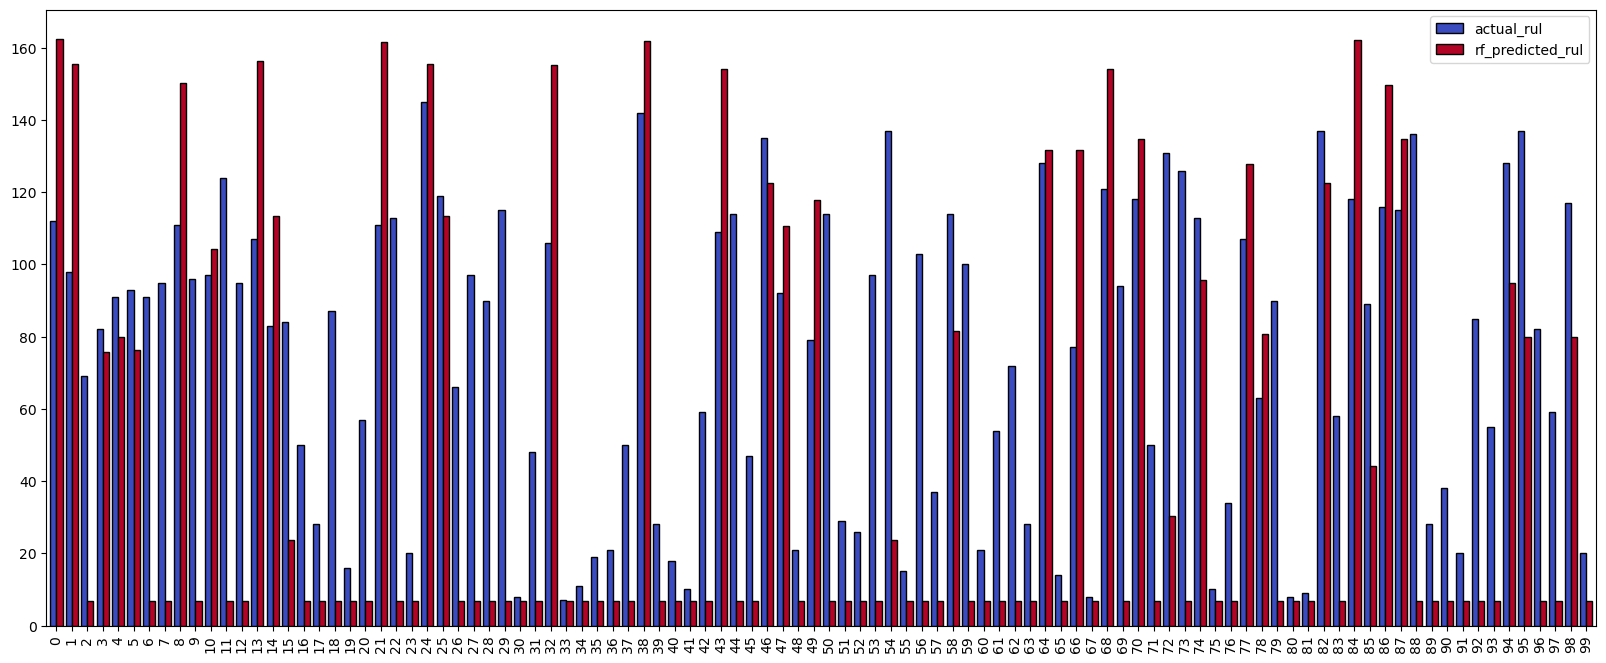

In [20]:
rf_pred_df = pd.DataFrame({'actual_rul': y_test.reshape(-1), 'rf_predicted_rul': rf_pred})
rf_pred_df.plot(kind='bar', figsize=(20, 8), width=0.8, colormap="coolwarm", edgecolor="black")

<Axes: >

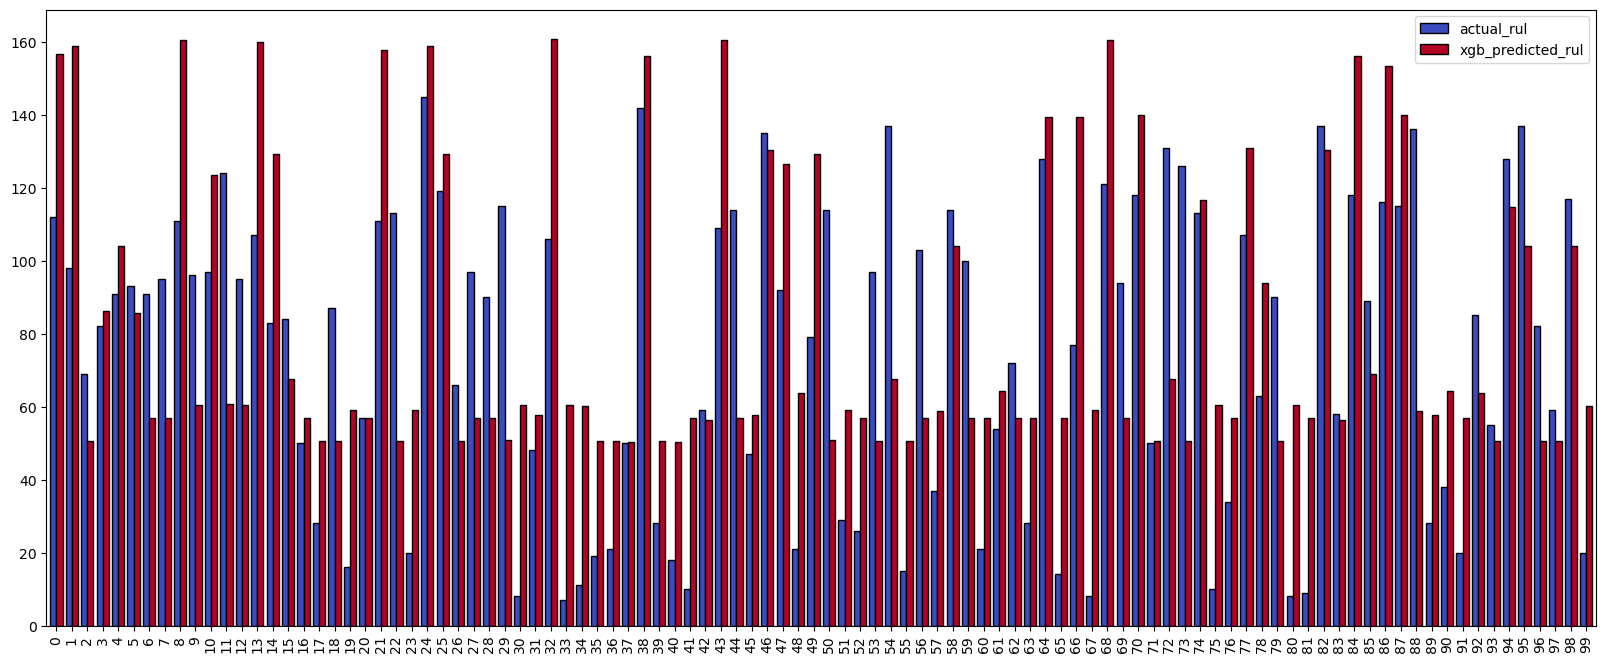

In [21]:
xgb_pred_df = pd.DataFrame({'actual_rul': y_test.reshape(-1), 'xgb_predicted_rul': xgb_pred})
xgb_pred_df.plot(kind='bar', figsize=(20, 8), width=0.8, colormap="coolwarm", edgecolor="black")

### Summary 
We found the XGBoost model to be a better and more consistent performer(RMSE=37.71). This was expected as XGBoost handles unbalanced datasets well. Note that there are some overestimation of RUL by the model. This can be either adjusted by changing sample weights or oversampling from lower rul records.